Documentation: https://docs.google.com/document/d/1fvkncgUI0B66McNnQyzSF1WOYz6O-UxDlKcipvpCjrY/edit

This version includes the prediction strength that allows, depending on the value, to borrow money from the bank.

First of all, we have to load our data so we create a function to do so. We are going to get it from YahooFinance.

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
from pandas_datareader import data as pdr

def load_data(stock_name, start_date, end_date = []):
    
    yf.pdr_override()
    
    # Start date:
    start_year, start_month, start_day = start_date
    start = dt.datetime(start_year,start_month,start_day)
    
    # End date
    if end_date: 
        end_year, end_month, end_day = end_date
        end = dt.datetime(end_year,end_month,end_day)
    else: # If no data is passed to end_date, we assume it is now 
        end = dt.datetime.now()

    df=pdr.get_data_yahoo(stock_name,start,end)
    
    # To change index from date to num:
    df = df.reset_index()
    
    return df
    
load_data("AAPL",[2022,1,1]).head() # Example

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-03,177.830002,182.880005,177.710007,182.009995,179.481125,104487900
1,2022-01-04,182.630005,182.940002,179.119995,179.699997,177.203217,99310400
2,2022-01-05,179.610001,180.169998,174.639999,174.919998,172.489609,94537600
3,2022-01-06,172.699997,175.300003,171.639999,172.000000,169.610199,96904000
4,2022-01-07,172.889999,174.139999,171.029999,172.169998,169.777832,86709100


Now, we are going to generate a sample data for the predictions in the selected time range:

In [2]:
import random

def sample_predictions_array(data, strength_100 = False):
    sample_predictions_df = pd.DataFrame(columns=["Date","Prediction"])
    for value in data.iterrows():
        date = value[1][0]    
        
        num_buy = random.randint(1,10)
        num_sell = random.randint(1,10)
        
        rand_num = random.uniform(0,1)
        strength = random.randint(50,100)
        if strength_100:
            if 0 < rand_num < 1/3:
                sample_predictions_df = pd.concat([sample_predictions_df,pd.DataFrame({"Date":[date], "Prediction":["Buy"], "Num Buy":[num_buy] , "Num Sell":[0], "Strength": [100]})], ignore_index=True)
            elif 1/3 < rand_num < 2/3:
                sample_predictions_df = pd.concat([sample_predictions_df,pd.DataFrame({"Date":[date], "Prediction":["Hold"], "Num Buy":[0] , "Num Sell":[0], "Strength": [100]})], ignore_index=True)
            elif 2/3 < rand_num < 1:
                sample_predictions_df = pd.concat([sample_predictions_df,pd.DataFrame({"Date":[date], "Prediction":["Sell"], "Num Buy":[0] , "Num Sell":[num_sell], "Strength": [100]})], ignore_index=True)
        else:
            if 0 < rand_num < 1/3:
                sample_predictions_df = pd.concat([sample_predictions_df,pd.DataFrame({"Date":[date], "Prediction":["Buy"], "Num Buy":[num_buy] , "Num Sell":[0], "Strength": [strength]})], ignore_index=True)
            elif 1/3 < rand_num < 2/3:
                sample_predictions_df = pd.concat([sample_predictions_df,pd.DataFrame({"Date":[date], "Prediction":["Hold"], "Num Buy":[0] , "Num Sell":[0], "Strength": [0]})], ignore_index=True)
            elif 2/3 < rand_num < 1:
                sample_predictions_df = pd.concat([sample_predictions_df,pd.DataFrame({"Date":[date], "Prediction":["Sell"], "Num Buy":[0] , "Num Sell":[num_sell], "Strength": [strength]})], ignore_index=True)
            
            
    return sample_predictions_df

sample_predictions_array(load_data("AAPL",[2022,1,1])).head()

[*********************100%***********************]  1 of 1 completed


,Date,Prediction,Num Buy,Num Sell,Strength
0,2022-01-03,Buy,8.0,0.0,50.0
1,2022-01-04,Buy,6.0,0.0,96.0
2,2022-01-05,Buy,10.0,0.0,96.0
3,2022-01-06,Sell,0.0,7.0,87.0
4,2022-01-07,Sell,0.0,10.0,83.0


We create a function to get the total amount of money that we owe to the bank:

In [3]:
def total_money_owed(money_owed_dict):
    total_sum = 0
    for borrowing_index in money_owed_dict.keys():
        total_sum += money_owed_dict[borrowing_index]["Money owed"]
    return total_sum

example = { 1: {'Money owed': 5}, 4: {'Money owed': 10}}
example[9] = {'Money owed' : 14}
total_money_owed(example)

29

We create a function that returns the money that needs to be returned given an initial borrowed money and the date that it was borrowed:

In [4]:
from math import exp
def update_owed_money(borrowing_index,borrowed_money,index,interest_rate):
    # We use the indexes instead of the dates to calculate the difference in trading days because it is different from the number in natural days:
    days = index - borrowing_index 
    return borrowed_money * exp(interest_rate * days / 252)


print(update_owed_money(1,100,253,0.0487))
print(exp(0.0487)*100)

104.99053318899962
104.99053318899962


In [5]:
borrowing_strength_threshold = 75

Now we create our backtesting strategy:

In [6]:
import math

def backtest(stock_name, initial_capital, interest_rate, predictions_array, start_date, end_date = []):
    
    # Load the Yahoo Finance data for the time range:
    data = load_data(stock_name, start_date, end_date)

    # The first thing we do is merge both dfs into one to make it more accessible:
    complete_df = pd.merge(data, predictions_array, on="Date")
    
    # Drop the colums we are not going to use:
    complete_df = complete_df.drop("High",axis=1)
    complete_df = complete_df.drop("Low",axis=1)
    complete_df = complete_df.drop("Volume",axis=1)
    complete_df = complete_df.drop("Close",axis=1) # We don't use the Close Price 
    complete_df = complete_df.drop("Adj Close",axis=1) # Nor do we use the Adj Close Price 
    
    # Create the columns we are going to use:
    complete_df["Real Num Buy"] = 0
    complete_df["Amount of shares"] = 0
    complete_df["Daily interest paid ($)"] = 0
    complete_df["Total money owed ($)"] = 0
    complete_df["Total interest paid ($)"] = 0
    complete_df["Invested money ($)"] = 0
    complete_df["Tomorrow's Available money ($)"] = 0
    complete_df["Tomorrow's open - Today's open ($)"] = 0
    complete_df["Daily profit ($)"] = 0
    complete_df["Net profit ($)"] = 0
    complete_df["Capital ($)"] = 0


    daily_profit = 0
    money_owed_dict = {}
    
    # Backtest:
    for value in complete_df.iterrows():
        # The variables we need to use:
        index = value[0]
        date = value[1][0]
        open_price = value[1][1]
        pred = value[1][2]
        num_buy = value[1][3]
        num_sell = value[1][4]
        strength = value[1][5]
        
        
        # NEW LOGIC FOR THE 2ND APPROACH:
        
        daily_interest = 0

        if money_owed_dict: # If we own any money
            
            # The first thing we do each day is update the money we owe:
            for borrowing_index in money_owed_dict.keys():
                # Firstly we compute the daily interest generated:
                daily_interest += (update_owed_money(borrowing_index,money_owed_dict[borrowing_index]["Borrowed money"],index,interest_rate) - money_owed_dict[borrowing_index]["Money owed"])
                # Daily interest could be computed as well using the total_money_owed (it is the same)
                
                # Now we update the money we owe and leave the borrowed money as it is:
                money_owed_dict[borrowing_index]["Money owed"] = update_owed_money(borrowing_index,money_owed_dict[borrowing_index]["Borrowed money"],index,interest_rate)
            
            # We update the column in complete_df of the money owed by the daily interet generated:
            complete_df.loc[index,"Total money owed ($)"] = total_money_owed(money_owed_dict)
        
        # Now we add the daily interest to the complete_df columns:
        if index > 0:
            complete_df.loc[index,"Daily interest paid ($)"] = daily_interest
            complete_df.loc[index,"Total interest paid ($)"] = complete_df.loc[index-1,"Total interest paid ($)"] + daily_interest

        if index < (complete_df.shape[0]-1): # Because of how we have constructed our engine, the last day doesn't matter:
            
            if index == 0: # The first day:
                if pred == "Buy":
                    # We check if we have enough money to buy all the shares that we have to:
                    if initial_capital > num_buy*open_price:
                        complete_df.loc[index,"Real Num Buy"] = num_buy
                        complete_df.loc[index,"Amount of shares"] = num_buy
                        complete_df.loc[index,"Invested money ($)"] = num_buy*open_price
                        complete_df.loc[index,"Tomorrow's Available money ($)"] = initial_capital - num_buy*open_price
                    else:
                        if strength > borrowing_strength_threshold: # If we don't have enough money but it is a strong buy, we borrow money from the bank:
                            needed_money = num_buy*open_price - initial_capital
                            complete_df.loc[index,"Total money owed ($)"] = needed_money
                            # print(f"Borrowing {round(needed_money,3)}$ on {date}")
                            money_owed_dict[index] = {'Money owed': needed_money, 'Borrowed money': needed_money}
                            complete_df.loc[index,"Real Num Buy"] = num_buy
                            complete_df.loc[index,"Amount of shares"] = num_buy
                            complete_df.loc[index,"Invested money ($)"] = num_buy*open_price
                            complete_df.loc[index,"Tomorrow's Available money ($)"] = 0
                        
                        else: # If we don't have enough money and it is not a strong buy, we buy as many shares as we can:
                            num = math.floor(initial_capital/open_price)
                            complete_df.loc[index,"Total money owed ($)"] = 0
                            complete_df.loc[index,"Real Num Buy"] = num
                            complete_df.loc[index,"Amount of shares"] = num
                            complete_df.loc[index,"Invested money ($)"] = num*open_price
                            complete_df.loc[index,"Tomorrow's Available money ($)"] = initial_capital - num*open_price
                    
                elif pred == "Hold":
                    complete_df.loc[index,"Amount of shares"] = 0
                    complete_df.loc[index,"Tomorrow's Available money ($)"] = initial_capital
            
                elif pred == "Sell":
                    complete_df.loc[index,"Amount of shares"] = 0
                    complete_df.loc[index,"Tomorrow's Available money ($)"] = initial_capital

            else: # The rest of the days:
                if pred == "Buy":
                    # We check if we have enough money to buy all the shares that we have to:
                    if complete_df.loc[index-1,"Tomorrow's Available money ($)"] > num_buy*open_price:
                        complete_df.loc[index,"Real Num Buy"] = num_buy
                        complete_df.loc[index,"Amount of shares"] = complete_df.loc[index-1,"Amount of shares"] + num_buy
                        complete_df.loc[index,"Invested money ($)"] = complete_df.loc[index-1,"Invested money ($)"] + num_buy*open_price
                        complete_df.loc[index,"Tomorrow's Available money ($)"] = complete_df.loc[index-1,"Tomorrow's Available money ($)"] - num_buy*open_price
                    else:
                        if strength > 75: # If we don't have enough money but it is a strong buy, we borrow money from the bank:
                            needed_money = num_buy*open_price - complete_df.loc[index-1,"Tomorrow's Available money ($)"]
                            complete_df.loc[index,"Total money owed ($)"] = complete_df.loc[index,"Total money owed ($)"] + needed_money
                            # print(f"Borrowing {round(needed_money,3)}$ on {date}")
                            money_owed_dict[index] = {'Money owed': needed_money, 'Borrowed money': needed_money}
                            complete_df.loc[index,"Real Num Buy"] = num_buy
                            complete_df.loc[index,"Amount of shares"] = complete_df.loc[index-1,"Amount of shares"] + num_buy
                            complete_df.loc[index,"Invested money ($)"] = complete_df.loc[index-1,"Invested money ($)"] + num_buy*open_price
                            complete_df.loc[index,"Tomorrow's Available money ($)"] = 0
                        
                        else: # If we don't have enough money and it is not a strong buy, we buy as many shares as we can:
                            num = math.floor(complete_df.loc[index-1,"Tomorrow's Available money ($)"]/open_price)
                            complete_df.loc[index,"Real Num Buy"] = num
                            complete_df.loc[index,"Amount of shares"] = complete_df.loc[index-1,"Amount of shares"] + num
                            complete_df.loc[index,"Invested money ($)"] = complete_df.loc[index-1,"Invested money ($)"] + num*open_price
                            complete_df.loc[index,"Tomorrow's Available money ($)"] = complete_df.loc[index-1,"Tomorrow's Available money ($)"] - num*open_price
                        
                elif pred == "Hold":
                    complete_df.loc[index,"Amount of shares"] = complete_df.loc[index-1,"Amount of shares"]
                    complete_df.loc[index,"Invested money ($)"] = complete_df.loc[index-1,"Invested money ($)"]
                    complete_df.loc[index,"Tomorrow's Available money ($)"] = complete_df.loc[index-1,"Tomorrow's Available money ($)"]

                elif pred == "Sell":
                    if complete_df.loc[index-1,"Amount of shares"] > 0: # We check if we have stocks to sell (we don't accept short-selling):
                    
                        if num_sell < complete_df.loc[index-1,"Amount of shares"]: # If we have more stocks than we have to sell:
                            complete_df.loc[index,"Amount of shares"] = complete_df.loc[index-1,"Amount of shares"] - num_sell
                            complete_df.loc[index,"Invested money ($)"] = complete_df.loc[index-1,"Invested money ($)"] - num_sell*open_price
                            complete_df.loc[index,"Tomorrow's Available money ($)"] = complete_df.loc[index-1,"Tomorrow's Available money ($)"] + num_sell*open_price

                        else: # If we have less stocks than we have to sell we just sell all of them:
                            complete_df.loc[index,"Tomorrow's Available money ($)"] = complete_df.loc[index-1,"Tomorrow's Available money ($)"] + complete_df.loc[index-1,"Amount of shares"]*open_price
                            complete_df.loc[index,"Amount of shares"] = 0
                            complete_df.loc[index,"Invested money ($)"] = 0 # Set invested money to 0 if we run out of stocks, check the documentation
                                                                            
                            
                    else: # If we don't have stocks to sell we have to update Tomorrow's Available money to the same as the day before:
                        complete_df.loc[index,"Tomorrow's Available money ($)"] = complete_df.loc[index-1,"Tomorrow's Available money ($)"]
                      
                    
                # Now we may have enough money to return to the bank part of the money that we owe:
                if money_owed_dict:
                    # This first step is to check how much money we can return to the bank:
                    borrowing_indexes_to_return = [] # The days from which we can return the borrowed money:
                    money_return_aux = 0 # An auxiliar variable to check how much money we can return
                    for borrowing_index in money_owed_dict.keys():
                        # This adds the money of each day in chronological order:
                        if (money_return_aux + money_owed_dict[borrowing_index]["Money owed"]) < complete_df.loc[index,"Tomorrow's Available money ($)"]:
                            money_return_aux += money_owed_dict[borrowing_index]["Money owed"]
                            borrowing_indexes_to_return.append(borrowing_index)


                    # We need to create this copy in the 3rd approach in order for the engine to work when we can return
                    # more than 2 indexes on a day
                    borrowing_indexes_to_return_copy = [*borrowing_indexes_to_return]

                    # Now that we know what amount of money we can return and to which days it corresponds, we return it:
                    for return_index in borrowing_indexes_to_return_copy:
                        # We substract the money owed from tomorrow's available money:
                        complete_df.loc[index,"Tomorrow's Available money ($)"] = complete_df.loc[index,"Tomorrow's Available money ($)"] - money_owed_dict[return_index]["Money owed"] 
                        # We substract "Money owed" and not "Borrowed money" because Tomorrow's available money hasn't been updated by the daily_interest

                        # We update the column in complete_df
                        complete_df.loc[index,"Total money owed ($)"] = complete_df.loc[index,"Total money owed ($)"] - money_owed_dict[return_index]["Money owed"] 


                        # Remove the index from the list of returning indexes and from the money owed dict:
                        del money_owed_dict[return_index]
                        borrowing_indexes_to_return.remove(return_index)
            
                
        # Compute the different metrics:

        if index == 0: # The first day
            complete_df.loc[index,"Tomorrow's open - Today's open ($)"] = complete_df.loc[index+1,"Open"] - complete_df.loc[index,"Open"]
            complete_df.loc[index,"Daily profit ($)"] = complete_df.loc[index,"Tomorrow's open - Today's open ($)"]*complete_df.loc[index,"Amount of shares"]
            complete_df.loc[index,"Net profit ($)"] = complete_df.loc[index,"Daily profit ($)"]
            
        elif index < (complete_df.shape[0]-1): # All the days except the first and the last one
            complete_df.loc[index,"Tomorrow's open - Today's open ($)"] = complete_df.loc[index+1,"Open"] - complete_df.loc[index,"Open"]
            complete_df.loc[index,"Daily profit ($)"] = complete_df.loc[index,"Tomorrow's open - Today's open ($)"]*complete_df.loc[index,"Amount of shares"]
            complete_df.loc[index,"Net profit ($)"] = complete_df.loc[index-1,"Net profit ($)"] + complete_df.loc[index,"Daily profit ($)"]

        else: # The last day
            complete_df.loc[index,"Net profit ($)"] = complete_df.loc[index-1,"Net profit ($)"]
            complete_df.loc[index,"Invested money ($)"] = complete_df.loc[index-1,"Invested money ($)"]
            complete_df.loc[index,"Amount of shares"] = complete_df.loc[index-1,"Amount of shares"]
            complete_df.loc[index,"Tomorrow's Available money ($)"] = complete_df.loc[index-1,"Tomorrow's Available money ($)"]
        
            # What we set to NaN because doesn't appear on the last day:
            complete_df.loc[index,"Daily profit ($)"] = np.nan 
            complete_df.loc[index,"Prediction"] = np.nan
            complete_df.loc[index,"Num Buy"] = np.nan
            complete_df.loc[index,"Num Sell"] = np.nan
            complete_df.loc[index,"Strength"] = np.nan
            complete_df.loc[index,"Real Num Buy"] = np.nan
            complete_df.loc[index,"Tomorrow's open - Today's open ($)"] = np.nan
        

        # We need to update the invested money by the daily profit of that day (before updating it by the daily interest):
        if index < (complete_df.shape[0]-1):
            complete_df.loc[index,"Invested money ($)"] = complete_df.loc[index,"Invested money ($)"] + complete_df.loc[index,"Daily profit ($)"]
            
        # We compute here the capital:
        complete_df.loc[index,"Capital ($)"] = complete_df.loc[index,"Invested money ($)"] + complete_df.loc[index,"Tomorrow's Available money ($)"] - complete_df.loc[index,"Total money owed ($)"]
        # Here, "Total money owed" is the only variable that is updated by the daily interest, what indeed it is what makes sense, hence the capital is also affected by the daily interest
        
        # We substract here the daily interest generated from Daily profit & Net profit:
        complete_df.loc[index,"Daily profit ($)"] = complete_df.loc[index,"Daily profit ($)"] - daily_interest
        complete_df.loc[index,"Net profit ($)"] = complete_df.loc[index,"Net profit ($)"] - daily_interest
    
    
        # Some security measures to see if everything is okay:
        
        if abs(complete_df.loc[index,"Net profit ($)"] - (complete_df.loc[index,"Capital ($)"] - initial_capital)) > 0.1:
            # This is a good security measure as these two cuantities are computed differently but should follow this relation: Net profit = Capital - Initial Capital
            print("Problem")
            print(date)
            
        if complete_df.loc[index,"Tomorrow's Available money ($)"] < 0:
            print("Negative available money:",date)        
        
        if complete_df.loc[index,"Invested money ($)"] < 0:
            print("Something failed")
            print(date)
    

    # We round these columns to have them cleaner and we do it here so the precision in the decimals doesn't affect the results:  
    complete_df["Tomorrow's open - Today's open ($)"] = round(complete_df["Tomorrow's open - Today's open ($)"],3)
    complete_df["Daily profit ($)"] = round(complete_df["Daily profit ($)"],3)
    complete_df["Invested money ($)"] = round(complete_df["Invested money ($)"],3)
    complete_df["Net profit ($)"] = round(complete_df["Net profit ($)"],3)
    complete_df["Capital ($)"] = round(complete_df["Capital ($)"],3)
    complete_df["Tomorrow's Available money ($)"] = round(complete_df["Tomorrow's Available money ($)"],3)
    complete_df["Total money owed ($)"] = round(complete_df["Total money owed ($)"],3)
    complete_df["Total interest paid ($)"] = round(complete_df["Total interest paid ($)"],3)
    complete_df["Daily interest paid ($)"] = round(complete_df["Daily interest paid ($)"],3)
    
    print(f"\nNet profit in the selected period: {complete_df.loc[index,'Net profit ($)']}$")   

    return complete_df
    

The logic used for the daily profit is that we buy/sell at the start of the day, so the daily profit is computed as the amount of shares we have that day multplied by the difference between the open price the next day and the open price for the stock that day. Therefore, selling or buying stocks doesn't affect to our profit but only does it the change in the price of that stock between the open price of that day and the open price of the next day.

In [23]:
stock_name_sample = "AMZN"
initial_capital_sample = 0
interest_rate_sample = 0.0487
start_date_sample = [2020,1,1]
# end_date_sample = [2020,8,1]
end_date_sample = []

# random.seed(29)

data_sample = load_data(stock_name_sample, start_date_sample,end_date_sample)
predictions_sample = sample_predictions_array(data_sample,strength_100=True) 
# Set strength_100 = False if backend provides strength

data = backtest(stock_name_sample,initial_capital_sample,interest_rate_sample,predictions_sample,start_date_sample,end_date_sample)
# data.to_excel("data.xlsx")
data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Net profit in the selected period: 7231.876$


,Date,Open,Prediction,Num Buy,Num Sell,Strength,Real Num Buy,Amount of shares,Daily interest paid ($),Total money owed ($),Total interest paid ($),Invested money ($),Tomorrow's Available money ($),Tomorrow's open - Today's open ($),Daily profit ($),Net profit ($),Capital ($)
0,2020-01-02,93.750000,Hold,0.0,0.0,100.0,0.0,0,0.000,0.000,0.000,0.000,0.000,-0.525,0.000,0.000,0.000
1,2020-01-03,93.224998,Hold,0.0,0.0,100.0,0.0,0,0.000,0.000,0.000,0.000,0.000,-0.225,0.000,0.000,0.000
2,2020-01-06,93.000000,Sell,0.0,10.0,100.0,0.0,0,0.000,0.000,0.000,0.000,0.000,2.225,0.000,0.000,0.000
3,2020-01-07,95.224998,Hold,0.0,0.0,100.0,0.0,0,0.000,0.000,0.000,0.000,0.000,-0.323,0.000,0.000,0.000
4,2020-01-08,94.902000,Sell,0.0,10.0,100.0,0.0,0,0.000,0.000,0.000,0.000,0.000,0.592,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,2024-05-24,181.649994,Sell,0.0,3.0,100.0,0.0,206,5.840,29608.214,1183.074,37065.578,110.658,-1.720,-360.161,7568.023,7568.023
1107,2024-05-28,179.929993,Buy,5.0,0.0,100.0,5.0,211,5.722,30402.928,1188.797,38338.699,0.000,1.770,367.748,7935.772,7935.772
1108,2024-05-29,181.699997,Sell,0.0,9.0,100.0,0.0,202,5.876,29024.627,1194.673,36624.620,251.123,-0.390,-84.656,7851.116,7851.116
1109,2024-05-30,181.309998,Hold,0.0,0.0,100.0,0.0,202,5.610,29030.237,1200.282,36016.601,251.123,-3.010,-613.629,7237.487,7237.487


This code should work because when setting an initial capital enough to don't borrow money at any time, it gives a difference in the net profit equals to the total interest paid when a 0$ initial_capital is provided (which is the beahviour we expect)

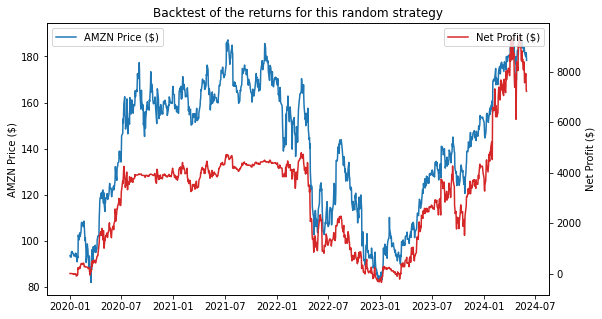

In [25]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(9, 5))
ax1.set_ylabel(f"{stock_name_sample} Price ($)")
ax1.plot(data["Date"], data["Open"], color='tab:blue', label=f"{stock_name_sample} Price ($)")
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel("Net Profit ($)")
ax2.plot(data["Date"], data["Net profit ($)"], color='tab:red', label="Net Profit ($)")
ax2.legend(loc='upper right')

plt.title("Backtest of the returns for this random strategy")
plt.show()
